In [2]:
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import time
import os.path
import scipy
import pickle as pickle
from struct import unpack
from brian2 import *
import brian2
from brian2tools import *
from PIL import Image
import scipy.signal as signal
import warnings
warnings.simplefilter('ignore')
import random

In [3]:
# initial random weights
dataPath = './initial_weights/'

field_size = 2                     # 2/3/4/5/6
w_s = field_size*1                # simple cell width
l_s = field_size*2                # simple_cell_length

c_length = 30
r_length = (c_length*l_s)   # (c_length*2*w_s)
orientations = 4

n_LGN = r_length*r_length
n_L4  = c_length*c_length
n_L3  = n_L4
n_L2  = n_L3

weight = {}
weight['LGN_L4'] = 10
weight['L4_L4'] = 7*18
weight['L4_L3_round'] = 0.1*18
weight['L4_L3_direct'] = 5*18
# weight['L3_L3'] = 7
# weight['L3_L2'] = 7
# weight['L2_L3'] = 7*18

In [4]:
# orientation map generations

grid = np.rint(np.random.random((c_length, c_length)) * (orientations-1))
counter = 1
while(True):
    counts = np.sort(np.unique(grid,return_counts=True)[1])
    if ( (counts[-1] < n_L4/(orientations-1)) and (counts[0] > n_L4/(orientations+1.5)) ):
        break
    grid = np.rint(np.random.random((c_length, c_length)) * (orientations-1))
    counter += 1
    
counts = np.unique(grid, return_counts=True)[1]
d1_index, d2_index, v_index, h_index = counts.argsort()

print('h', h_index, counts[h_index])
print('v', v_index, counts[v_index])
print('d2', d2_index, counts[d2_index])
print('d1', d1_index, counts[d1_index])

h 1 289
v 2 254
d2 0 185
d1 3 172


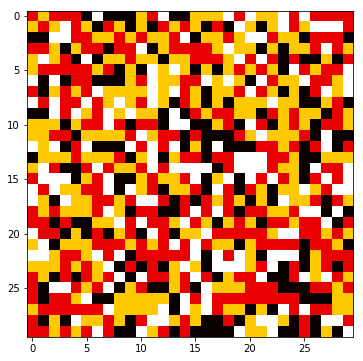

In [8]:
figure(figsize = (6,6))
im2 = imshow(grid, cmap = cmap.get_cmap('hot'))
# colorbar(im2)

In [6]:
# LGN ON >> L4 horizontal   (NF connection)
# LGN OFF >> L4 horizontal  (FN connection)

weightList = np.random.random((n_LGN, n_L4))
weightList += weight['LGN_L4']

weights_NF = []
weights_FN = []

for i in range(0, c_length):
    for j in range(0, c_length):
        
        if (grid[i][j] == h_index):
            for p in range(0, w_s):
                for q in range(0, l_s):
                    x_NF = (i*2*w_s+p) * r_length + (j*l_s+q)
                    x_FN = ((i*2+1)*w_s+p) * r_length + (j*l_s+q)
                    y = i * c_length + j

                    weights_NF.append((x_NF, y, weightList[x_NF,y]))
                    weights_FN.append((x_FN, y, weightList[x_FN,y]))
            
        elif (grid[i][j] == v_index):
            for p in range(0, l_s):
                for q in range(0, w_s):
                    x_NF = (i*l_s+p) * r_length + (j*2*w_s+q)
                    x_FN = (i*l_s+p) * r_length + ((j*2+1)*w_s+q)
                    y = i * c_length + j

                    weights_NF.append((x_NF, y, weightList[x_NF,y]))
                    weights_FN.append((x_FN, y, weightList[x_FN,y]))
            
        elif (grid[i][j] == d1_index):
            x_NF_list = [
                (i*l_s+0)*r_length + (j*2*w_s+0), (i*l_s+0)*r_length + (j*2*w_s+1), (i*l_s+0)*r_length + (j*2*w_s+2),
                (i*l_s+1)*r_length + (j*2*w_s+0), (i*l_s+1)*r_length + (j*2*w_s+1),
                (i*l_s+2)*r_length + (j*2*w_s+0)
            ]
            x_FN_list = [
                (i*l_s+1)*r_length + (j*2*w_s+3),
                (i*l_s+2)*r_length + (j*2*w_s+2), (i*l_s+2)*r_length + (j*2*w_s+3),
                (i*l_s+3)*r_length + (j*2*w_s+1), (i*l_s+3)*r_length + (j*2*w_s+2), (i*l_s+3)*r_length + (j*2*w_s+3)
            ]
            y = i * c_length + j

            for x_NF in x_NF_list:
                weights_NF.append((x_NF, y, weightList[x_NF,y]))
            for x_FN in x_FN_list:
                weights_FN.append((x_FN, y, weightList[x_FN,y]))
            
        elif (grid[i][j] == d2_index):
            x_NF_list = [
                (i*l_s+0)*r_length + (j*2*w_s+1), (i*l_s+0)*r_length + (j*2*w_s+2), (i*l_s+0)*r_length + (j*2*w_s+3),
                (i*l_s+1)*r_length + (j*2*w_s+2), (i*l_s+1)*r_length + (j*2*w_s+3),
                (i*l_s+2)*r_length + (j*2*w_s+3)
            ]
            x_FN_list = [
                (i*l_s+1)*r_length + (j*2*w_s+0),
                (i*l_s+2)*r_length + (j*2*w_s+0), (i*l_s+2)*r_length + (j*2*w_s+1),
                (i*l_s+3)*r_length + (j*2*w_s+0), (i*l_s+3)*r_length + (j*2*w_s+1), (i*l_s+3)*r_length + (j*2*w_s+2)
            ]
            y = i* c_length + j

            for x_NF in x_NF_list:
                weights_NF.append((x_NF, y, weightList[x_NF,y]))
            for x_FN in x_FN_list:
                weights_FN.append((x_FN, y, weightList[x_FN,y]))   
        
        
np.save(dataPath + 'LGN_L4_NF', weights_NF)
np.save(dataPath + 'LGN_L4_FN', weights_FN)

In [ ]:
# LGN ON >> L4 horizontal
# LGN OFF >> L4 horizontal
# feedforward, simple_cell_length*simple_cell_width to 1

weightList = np.random.random((n_LGN, n_L4))
weightList += weight['LGN_L4']

weights_on = []
weights_off = []

for i in range(0, c_length):                       # y axis
    for j in range(0, c_length):                   # x axis
        if (grid[i][j] == h_index):
            for p in range(0, w_s):
                for q in range(0, l_s):
                    x_on = (i*2*w_s+p) * r_length + (j*l_s+q)
                    x_off = ((i*2+1)*w_s+p) * r_length + (j*l_s+q)
                    y = i*c_length + j

                    weights_on.append((x_on, y, weightList[x_on,y]))
                    weights_off.append((x_off, y, weightList[x_off,y]))
        
np.save(dataPath + 'LGN_L4_h_on', weights_on)
np.save(dataPath + 'LGN_L4_h_off', weights_off)

In [ ]:
# LGN ON >> L4 vertical
# LGN OFF >> L4 vertical
# feedforward, simple_cell_length*simple_cell_width to 1

weightList = np.random.random((n_LGN, n_L4))
weightList += weight['LGN_L4']

weights_on = []
weights_off = []

for i in range(0, c_length):                   # y axis
    for j in range(0, c_length):               # x axis
        if (grid[i][j] == v_index):
            for p in range(0, l_s):
                for q in range(0, w_s):
                    x_on = (i*l_s+p) * r_length + (j*2*w_s+q)
                    x_off = (i*l_s+p) * r_length + ((j*2+1)*w_s+q)
                    y = i * c_length + j

                    weights_on.append((x_on, y, weightList[x_on,y]))
                    weights_off.append((x_off, y, weightList[x_off,y]))

np.save(dataPath + 'LGN_L4_v_on', weights_on)
np.save(dataPath + 'LGN_L4_v_off', weights_off)

In [ ]:
# LGN ON >> L4 diagonal (45 left)
# LGN OFF >> L4 diagonal (45 left)
# feedforward, simple_cell_length*simple_cell_width to 1

weightList = np.random.random((n_LGN, n_L4))
weightList += weight['LGN_L4']

weights_on = []
weights_off = []

for i in range(0, c_length):                   # y axis
    for j in range(0, c_length):           # x axis
        if (grid[i][j] == d1_index):
            x_on_list = [
                (i*l_s+0)*r_length + (j*2*w_s+0), (i*l_s+0)*r_length + (j*2*w_s+1), (i*l_s+0)*r_length + (j*2*w_s+2),
                (i*l_s+1)*r_length + (j*2*w_s+0), (i*l_s+1)*r_length + (j*2*w_s+1),
                (i*l_s+2)*r_length + (j*2*w_s+0)
            ]
            x_off_list = [
                (i*l_s+1)*r_length + (j*2*w_s+3),
                (i*l_s+2)*r_length + (j*2*w_s+2), (i*l_s+2)*r_length + (j*2*w_s+3),
                (i*l_s+3)*r_length + (j*2*w_s+1), (i*l_s+3)*r_length + (j*2*w_s+2), (i*l_s+3)*r_length + (j*2*w_s+3)
            ]
            y = i * c_length + j

            for x_on in x_on_list:
                weights_on.append((x_on, y, weightList[x_on,y]))

            for x_off in x_off_list:
                weights_off.append((x_off, y, weightList[x_off,y]))
        
np.save(dataPath + 'LGN_L4_d1_on', weights_on)
np.save(dataPath + 'LGN_L4_d2_off', weights_off)

In [ ]:
# LGN ON >> L4 diagonal (135 right)
# LGN OFF >> L4 diagonal (135 right)
# feedforward, simple_cell_length*simple_cell_width to 1

weightList = np.random.random((n_LGN, n_L4))
weightList += weight['LGN_L4']

weights_on = []
weights_off = []

for i in range(0, c_length):                   # y axis
    for j in range(0, c_length):               # x axis
        if (grid[i][j] == d2_index):
            x_on_list = [
                (i*l_s+0)*r_length + (j*2*w_s+1), (i*l_s+0)*r_length + (j*2*w_s+2), (i*l_s+0)*r_length + (j*2*w_s+3),
                (i*l_s+1)*r_length + (j*2*w_s+2), (i*l_s+1)*r_length + (j*2*w_s+3),
                (i*l_s+2)*r_length + (j*2*w_s+3)
            ]
            x_off_list = [
                (i*l_s+1)*r_length + (j*2*w_s+0),
                (i*l_s+2)*r_length + (j*2*w_s+0), (i*l_s+2)*r_length + (j*2*w_s+1),
                (i*l_s+3)*r_length + (j*2*w_s+0), (i*l_s+3)*r_length + (j*2*w_s+1), (i*l_s+3)*r_length + (j*2*w_s+2)
            ]
            y = i* c_length + j

            for x_on in x_on_list:
                weights_on.append((x_on, y, weightList[x_on,y]))

            for x_off in x_off_list:
                weights_off.append((x_off, y, weightList[x_off,y]))
        
np.save(dataPath + 'LGN_L4_d2_on', weights_on)
np.save(dataPath + 'LGN_L4_d2_off', weights_off)